In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
import os
import sys
sys.path.append("..")
import util    # helper functions

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 14, 9, 41, 40, 683472)

In [3]:
# Get relevant secrets and variables

print("Connecting to Hopsworks...")
hopsworks_key = os.getenv("HOPSWORKS_API_KEY") 
hopsworks_project_name = os.getenv("HOPSWORKS_PROJECT")
project = hopsworks.login(project=hopsworks_project_name, api_key_value=hopsworks_key) 
fs = project.get_feature_store()

with open("../city_config/gothenburg_femman.json") as f:
    city_config = json.load(f)

country = city_config["city_name"]
city = city_config["country_name"]
street = city_config["street_name"]
LAT = city_config["city_lat"]
LON = city_config["city_lon"]
SENSOR = city_config["sensors"][0] 
FG_VERSIONS = city_config["fg_versions"]

feature_view = city_config["feature_view"]
feature_view_name = feature_view["name"]
feature_view_version = feature_view["version"]

model_registry = city_config["model_registry"]
model_name = model_registry["name"]
model_version = model_registry["version"]

Connecting to Hopsworks...
2025-11-14 09:41:40,713 INFO: Initializing external client
2025-11-14 09:41:40,714 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-14 09:41:41,380 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-14 09:41:42,125 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1271989


In [4]:
# Download the model from the model registry

mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name=model_name,
    version=model_version,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-14 09:41:46,234 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/1501170 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/107529 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27901 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/46341 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/42488 elapsed<00:00 remaining<?

In [5]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

,objective,'reg:squarederror'
,base_score,[26.62674]
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [6]:
# Get weather forecast features

forecast_fg = fs.get_feature_group(
    name='weather_forecast_features',
    version=FG_VERSIONS["weather_forecast_features"],
)
batch_data = forecast_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.95s) 


In [7]:
lagged_air_quality_fg = fs.get_feature_group(name='air_quality_lagged', version=FG_VERSIONS['air_quality_lagged'])
lagged_air_quality_df = lagged_air_quality_fg.read()
lagged_air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.93s) 


,date,pm2_5,country,city,street,pm2_5_lag_1,pm2_5_lag_2,pm2_5_lag_3
0,2024-01-20 00:00:00+00:00,23.0,Sweden,Göteborg,Femman,25.0,21.0,19.0
1,2023-10-11 00:00:00+00:00,23.0,Sweden,Göteborg,Femman,11.0,14.0,13.0
2,2025-03-28 00:00:00+00:00,84.0,Sweden,Göteborg,Femman,57.0,25.0,57.0
3,2021-02-14 00:00:00+00:00,47.0,Sweden,Göteborg,Femman,41.0,40.0,20.0
4,2021-08-26 00:00:00+00:00,11.0,Sweden,Göteborg,Femman,19.0,29.0,20.0
...,...,...,...,...,...,...,...,...
1841,2024-10-23 00:00:00+00:00,40.0,Sweden,Göteborg,Femman,43.0,46.0,51.0
1842,2021-03-14 00:00:00+00:00,11.0,Sweden,Göteborg,Femman,11.0,12.0,11.0
1843,2019-12-01 00:00:00+00:00,34.0,Sweden,Göteborg,Femman,36.0,10.0,19.0
1844,2025-05-12 00:00:00+00:00,21.0,Sweden,Göteborg,Femman,27.0,41.0,37.0


In [8]:
# Take the most recent observed lags and reuse those values for all upcoming forecast days
# Only keep recent lag columns and the date for merging with batch_data
lagged_air_quality_df_pred = lagged_air_quality_df[
    ['date', 'pm2_5_lag_1', 'pm2_5_lag_2', 'pm2_5_lag_3']
]

# Sort by date to get most recent row
latest_lag_row = lagged_air_quality_df_pred.sort_values('date').iloc[-1]

# Attach these latest lags to every forecast batch row
for i, col in enumerate(['pm2_5_lag_1', 'pm2_5_lag_2', 'pm2_5_lag_3']):
    batch_data.insert(i, col, latest_lag_row[col])

In [9]:
batch_data

,pm2_5_lag_1,pm2_5_lag_2,pm2_5_lag_3,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,temperature_2m_max,date
0,45.0,33.0,32.0,13.6,28.1,111,2.7,2025-11-19 00:00:00+00:00
1,45.0,33.0,32.0,11.2,22.3,46,6.5,2025-11-14 00:00:00+00:00
2,45.0,33.0,32.0,27.4,50.4,242,11.6,2025-11-13 00:00:00+00:00
3,45.0,33.0,32.0,12.5,28.8,342,2.7,2025-11-17 00:00:00+00:00
4,45.0,33.0,32.0,13.2,30.2,149,2.6,2025-11-18 00:00:00+00:00
5,45.0,33.0,32.0,19.8,36.0,271,8.8,2025-11-16 00:00:00+00:00
6,45.0,33.0,32.0,10.8,18.0,139,4.3,2025-11-15 00:00:00+00:00
7,45.0,33.0,32.0,8.8,25.6,27,0.0,2025-11-20 00:00:00+00:00


In [10]:
feature_cols = [
    'pm2_5_lag_1', 'pm2_5_lag_2', 'pm2_5_lag_3',
    'wind_speed_10m_max', 'wind_gusts_10m_max',
    'wind_direction_10m_dominant', 'temperature_2m_max'
]

In [11]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(batch_data[feature_cols])
batch_data

,pm2_5_lag_1,pm2_5_lag_2,pm2_5_lag_3,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,temperature_2m_max,date,predicted_pm25
0,45.0,33.0,32.0,13.6,28.1,111,2.7,2025-11-19 00:00:00+00:00,36.968254
1,45.0,33.0,32.0,11.2,22.3,46,6.5,2025-11-14 00:00:00+00:00,31.995335
2,45.0,33.0,32.0,27.4,50.4,242,11.6,2025-11-13 00:00:00+00:00,31.543056
3,45.0,33.0,32.0,12.5,28.8,342,2.7,2025-11-17 00:00:00+00:00,35.192932
4,45.0,33.0,32.0,13.2,30.2,149,2.6,2025-11-18 00:00:00+00:00,37.656769
5,45.0,33.0,32.0,19.8,36.0,271,8.8,2025-11-16 00:00:00+00:00,38.933529
6,45.0,33.0,32.0,10.8,18.0,139,4.3,2025-11-15 00:00:00+00:00,43.400772
7,45.0,33.0,32.0,8.8,25.6,27,0.0,2025-11-20 00:00:00+00:00,31.070717


In [12]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   pm2_5_lag_1                  8 non-null      float64                
 1   pm2_5_lag_2                  8 non-null      float64                
 2   pm2_5_lag_3                  8 non-null      float64                
 3   wind_speed_10m_max           8 non-null      float64                
 4   wind_gusts_10m_max           8 non-null      float64                
 5   wind_direction_10m_dominant  8 non-null      int64                  
 6   temperature_2m_max           8 non-null      float64                
 7   date                         8 non-null      datetime64[us, Etc/UTC]
 8   predicted_pm25               8 non-null      float32                
dtypes: datetime64[us, Etc/UTC](1), float32(1), float64(6), int64(1)
memory usage: 672

In [13]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country

# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,pm2_5_lag_1,pm2_5_lag_2,pm2_5_lag_3,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,temperature_2m_max,date,predicted_pm25,street,city,country,days_before_forecast_day
2,45.0,33.0,32.0,27.4,50.4,242,11.6,2025-11-13 00:00:00+00:00,31.543056,Femman,Sweden,Göteborg,3
1,45.0,33.0,32.0,11.2,22.3,46,6.5,2025-11-14 00:00:00+00:00,31.995335,Femman,Sweden,Göteborg,2
6,45.0,33.0,32.0,10.8,18.0,139,4.3,2025-11-15 00:00:00+00:00,43.400772,Femman,Sweden,Göteborg,7
5,45.0,33.0,32.0,19.8,36.0,271,8.8,2025-11-16 00:00:00+00:00,38.933529,Femman,Sweden,Göteborg,6
3,45.0,33.0,32.0,12.5,28.8,342,2.7,2025-11-17 00:00:00+00:00,35.192932,Femman,Sweden,Göteborg,4
4,45.0,33.0,32.0,13.2,30.2,149,2.6,2025-11-18 00:00:00+00:00,37.656769,Femman,Sweden,Göteborg,5
0,45.0,33.0,32.0,13.6,28.1,111,2.7,2025-11-19 00:00:00+00:00,36.968254,Femman,Sweden,Göteborg,1
7,45.0,33.0,32.0,8.8,25.6,27,0.0,2025-11-20 00:00:00+00:00,31.070717,Femman,Sweden,Göteborg,8


In [14]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, 2 to 7
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   pm2_5_lag_1                  8 non-null      float64                
 1   pm2_5_lag_2                  8 non-null      float64                
 2   pm2_5_lag_3                  8 non-null      float64                
 3   wind_speed_10m_max           8 non-null      float64                
 4   wind_gusts_10m_max           8 non-null      float64                
 5   wind_direction_10m_dominant  8 non-null      int64                  
 6   temperature_2m_max           8 non-null      float64                
 7   date                         8 non-null      datetime64[us, Etc/UTC]
 8   predicted_pm25               8 non-null      float32                
 9   street                       8 non-null      object                 
 10  city       

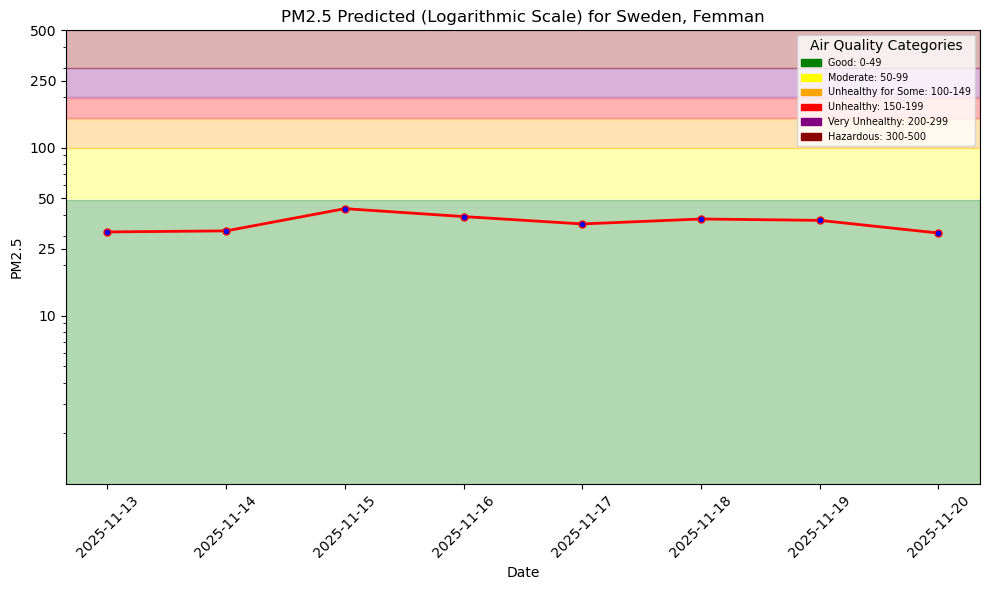

In [15]:
# Create a forecast graph:
# pred_file_path = "../docs/air-quality/assets/img/pm25_forecast.png"
pred_file_path = "../air_quality_model/images/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [16]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=FG_VERSIONS["aq_predictions"],
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [17]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 8/8 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1271989/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-14 09:42:14,598 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-14 09:43:05,756 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-14 09:44:45,084 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-14 09:44:45,235 INFO: Waiting for log aggregation to finish.
2025-11-14 09:44:53,841 INFO: Execution finished successfully.


(Job('aq_predictions_1_offline_fg_materialization', 'SPARK'), None)

In [18]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand (can view for more days)
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.49s) 


,pm2_5_lag_1,pm2_5_lag_2,pm2_5_lag_3,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,temperature_2m_max,date,predicted_pm25,street,city,country,days_before_forecast_day
0,45.0,33.0,32.0,13.6,28.1,111,2.7,2025-11-19 00:00:00+00:00,36.968254,Femman,Sweden,Göteborg,1


In [19]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=FG_VERSIONS["air_quality"])
air_quality_df = air_quality_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.86s) 


In [20]:
weather_fg = fs.get_feature_group(name='weather', version=FG_VERSIONS['weather'])

In [21]:
outcome_df = lagged_air_quality_df[['date', 'pm2_5']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

print(preds_df['date'].dtype)
print(outcome_df['date'].dtype)

print("Pred dates:", preds_df['date'].min(), "to", preds_df['date'].max())
print("Actual dates:", outcome_df['date'].min(), "to", outcome_df['date'].max())

print("Pred columns:", preds_df.columns)
print("Outcome df columns:", outcome_df.columns)

print("air quality columns:", air_quality_df.columns)


# hindcast_df = pd.merge(preds_df, outcome_df, on="date", how="left")     # Keep the future dates
hindcast_df = pd.merge(preds_df, outcome_df, on="date", how="inner") 
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

datetime64[us, Etc/UTC]
datetime64[us, Etc/UTC]
Pred dates: 2025-11-19 00:00:00+00:00 to 2025-11-19 00:00:00+00:00
Actual dates: 2019-11-06 00:00:00+00:00 to 2025-11-06 00:00:00+00:00
Pred columns: Index(['date', 'predicted_pm25'], dtype='object')
Outcome df columns: Index(['date', 'pm2_5'], dtype='object')
air quality columns: Index(['date', 'pm2_5', 'country', 'city', 'street'], dtype='object')
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.00s) 
FEATURES_DF COLUMNS: Index(['wind_speed_10m_max', 'wind_gusts_10m_max',
       'wind_direction_10m_dominant', 'temperature_2m_max', 'date', 'country',
       'city', 'street'],
      dtype='object')
                          date      city  street
794  2025-10-30 00:00:00+00:00  Göteborg  Femman
340  2025-10-31 00:00:00+00:00  Göteborg  Femman
433  2025-11-01 00:00:00+00:00  Göteborg  Femman
1290 2025-11-02 00:00:00+00:00  Göteborg  Femman
1167 2025-11-03 00:00:00+00:00  Göteborg  Femman
FEATURES_DF COLUMNS: 

Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1271989/jobs/named/aq_predictions_1_offline_fg_materialization/executions
2025-11-14 09:45:15,004 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-14 09:45:21,625 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-14 09:46:57,652 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-14 09:46:57,814 INFO: Waiting for log aggregation to finish.
2025-11-14 09:47:06,395 INFO: Execution finished successfully.


,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,temperature_2m_max,date,country,city,street,pm2_5_lag_1,pm2_5_lag_2,pm2_5_lag_3,predicted_pm25,days_before_forecast_day,pm2_5
0,19.8,40.0,345,8.6,2025-10-30 00:00:00+00:00,Sweden,Göteborg,Femman,31.0,18.0,14.0,24.374798,1,10.0
1,14.4,28.4,88,7.9,2025-10-31 00:00:00+00:00,Sweden,Göteborg,Femman,10.0,31.0,18.0,14.436120,1,12.0
2,22.6,45.0,146,11.6,2025-11-01 00:00:00+00:00,Sweden,Göteborg,Femman,12.0,10.0,31.0,24.925871,1,27.0
3,21.4,45.7,211,10.8,2025-11-02 00:00:00+00:00,Sweden,Göteborg,Femman,27.0,12.0,10.0,29.567804,1,42.0
4,24.4,47.9,194,10.9,2025-11-03 00:00:00+00:00,Sweden,Göteborg,Femman,42.0,27.0,12.0,36.556240,1,32.0
5,25.6,52.6,215,13.5,2025-11-04 00:00:00+00:00,Sweden,Göteborg,Femman,32.0,42.0,27.0,31.286697,1,33.0
6,20.5,43.9,187,12.2,2025-11-05 00:00:00+00:00,Sweden,Göteborg,Femman,33.0,32.0,42.0,35.548004,1,45.0
7,14.5,28.8,171,13.4,2025-11-06 00:00:00+00:00,Sweden,Göteborg,Femman,45.0,33.0,32.0,42.336380,1,34.0
8,34.0,67.3,191,11.1,2025-11-12 00:00:00+00:00,Sweden,Göteborg,Femman,34.0,45.0,33.0,34.657608,1,7.0
9,23.1,46.4,251,11.0,2025-11-13 00:00:00+00:00,Sweden,Göteborg,Femman,7.0,34.0,45.0,19.394480,1,2.3


In [22]:
hindcast_df

,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,temperature_2m_max,date,country,city,street,pm2_5_lag_1,pm2_5_lag_2,pm2_5_lag_3,predicted_pm25,days_before_forecast_day,pm2_5
0,19.8,40.0,345,8.6,2025-10-30 00:00:00+00:00,Sweden,Göteborg,Femman,31.0,18.0,14.0,24.374798,1,10.0
1,14.4,28.4,88,7.9,2025-10-31 00:00:00+00:00,Sweden,Göteborg,Femman,10.0,31.0,18.0,14.436120,1,12.0
2,22.6,45.0,146,11.6,2025-11-01 00:00:00+00:00,Sweden,Göteborg,Femman,12.0,10.0,31.0,24.925871,1,27.0
3,21.4,45.7,211,10.8,2025-11-02 00:00:00+00:00,Sweden,Göteborg,Femman,27.0,12.0,10.0,29.567804,1,42.0
4,24.4,47.9,194,10.9,2025-11-03 00:00:00+00:00,Sweden,Göteborg,Femman,42.0,27.0,12.0,36.556240,1,32.0
5,25.6,52.6,215,13.5,2025-11-04 00:00:00+00:00,Sweden,Göteborg,Femman,32.0,42.0,27.0,31.286697,1,33.0
6,20.5,43.9,187,12.2,2025-11-05 00:00:00+00:00,Sweden,Göteborg,Femman,33.0,32.0,42.0,35.548004,1,45.0
7,14.5,28.8,171,13.4,2025-11-06 00:00:00+00:00,Sweden,Göteborg,Femman,45.0,33.0,32.0,42.336380,1,34.0
8,34.0,67.3,191,11.1,2025-11-12 00:00:00+00:00,Sweden,Göteborg,Femman,34.0,45.0,33.0,34.657608,1,7.0
9,23.1,46.4,251,11.0,2025-11-13 00:00:00+00:00,Sweden,Göteborg,Femman,7.0,34.0,45.0,19.394480,1,2.3


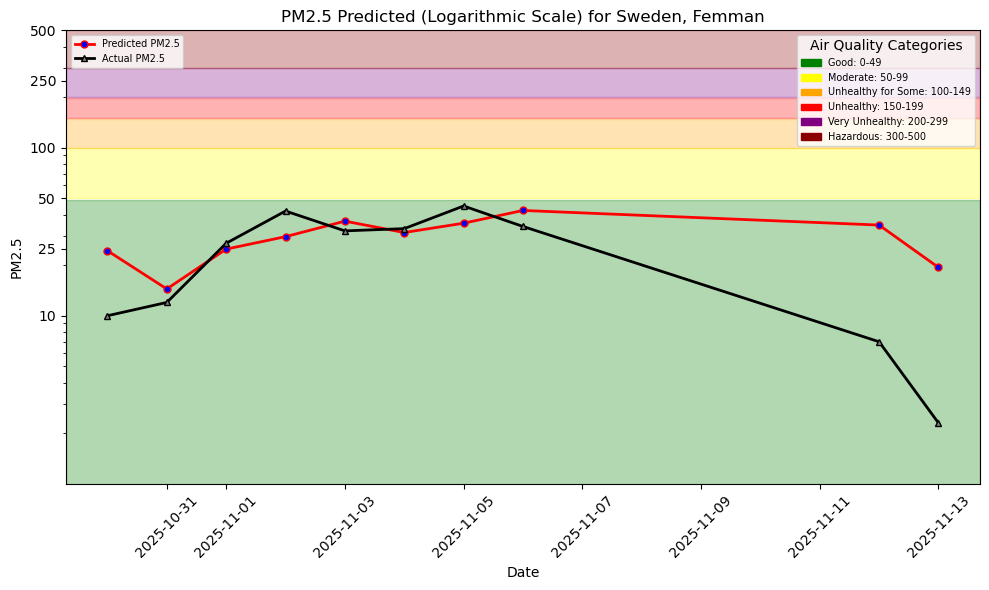

In [23]:
# Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)
# After a few days of predictions and observations, you will get data points in this graph.

hindcast_file_path = "../air_quality_model/images/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

In [24]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/kajsalidin/Desktop/ID2223_air_quality_prediction/pipelines/../air_quality_model/images/pm25_f…

Uploading /Users/kajsalidin/Desktop/ID2223_air_quality_prediction/pipelines/../air_quality_model/images/pm25_h…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1271989/settings/fb/path/Resources/airquality
